# Question Answering System Template Matching Part 
## Sentence Similarity (SentenceTransformers) + Linguistic Methods


## Importing the necessary packages

In [1]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from sklearn import metrics, manifold
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy import displacy

!pip3 install truecase
import truecase


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Load Questions and Templates

In [2]:
templates = pd.read_csv("TestTemplates.csv", sep='|', engine='python')
questions = pd.read_csv("TM_TestSet.csv")
templates.head()

,Template,Cypher
0,Historical Info about <Place>,"MATCH (p) WHERE p.ns0__name = ""<Place>"" RETURN..."
1,Villages of Santorini,"MATCH (start{ns0__name:""Santorini""})-[r:ns0__c..."
2,What is Santorini also known as?,"MATCH (start{ns0__name:""Santorini""})-[r:ns1__A..."
3,Myths about <Place>,"MATCH (start{ns0__name:""<Place>""})-[r:ns1__Myt..."
4,What do you know about <Place>?,"MATCH p=(start{ns0__name:""<Place>""})-[r]->(end..."


# Sentence Similarity

## Define Preprocessing Methods

In [3]:
#preprocessing and cleaning method 1

def utils_preprocess_text1(sentence):
  #Remove any < > references
  new_sentence = re.sub("<+[\w]*>", "", sentence)
    
  #Remove the word Santorini
  new_sentence = new_sentence.replace("Santorini", "")
  new_sentence = new_sentence.replace("santorini", "")
  
  return new_sentence

In [4]:
#preprocessing and cleaning method 2

'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text2(text, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

# Πειράματα 2.1

In [5]:
'''
#Πειραμα 2.1.1
#Cleaning Templates with utils_preprocess_text1

index=0
for sentence in templates["Template"]:
  templates.at[index,'Template_Clean1'] = utils_preprocess_text1(sentence)
  index=index+1

templates.head()

'''

'\n#Πειραμα 2.1.1\n#Cleaning Templates with utils_preprocess_text1\n\nindex=0\nfor sentence in templates["Template"]:\n  templates.at[index,\'Template_Clean1\'] = utils_preprocess_text1(sentence)\n  index=index+1\n\ntemplates.head()\n\n'

In [6]:
'''
#Πειραμα 2.1.2
#Cleaning Templates with utils_preprocess_text2

lst_stopwords = nltk.corpus.stopwords.words("english")
index=0
for sentence in templates["Template"]:
  templates.at[index,'Template_Clean2'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)
  index=index+1

templates.head()
'''

'\n#Πειραμα 2.1.2\n#Cleaning Templates with utils_preprocess_text2\n\nlst_stopwords = nltk.corpus.stopwords.words("english")\nindex=0\nfor sentence in templates["Template"]:\n  templates.at[index,\'Template_Clean2\'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)\n  index=index+1\n\ntemplates.head()\n'

In [7]:
'''
#Πειραμα 2.1.3
#Cleaning Templates with utils_preprocess_text + utils_preprocess_text2

lst_stopwords = nltk.corpus.stopwords.words("english")
index=0
for sentence in templates["Template"]:
  sentence = utils_preprocess_text1(sentence)
  templates.at[index,'Template_Clean3'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)
  
  index=index+1

templates.head()
'''

'\n#Πειραμα 2.1.3\n#Cleaning Templates with utils_preprocess_text + utils_preprocess_text2\n\nlst_stopwords = nltk.corpus.stopwords.words("english")\nindex=0\nfor sentence in templates["Template"]:\n  sentence = utils_preprocess_text1(sentence)\n  templates.at[index,\'Template_Clean3\'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)\n  \n  index=index+1\n\ntemplates.head()\n'

In [8]:
'''
#Πειραμα 2.1.4
#Cleaning Templates with utils_preprocess_text2 AND Cleaning Questions with utils_preprocess_text2

lst_stopwords = nltk.corpus.stopwords.words("english")
index=0
for sentence in templates["Template"]:
  templates.at[index,'Template_Clean2'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)
  index=index+1

index=0
for sentence in questions["text"]:
  questions.at[index,'Text_Clean1'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)
  index=index+1

'''

'\n#Πειραμα 2.1.4\n#Cleaning Templates with utils_preprocess_text2 AND Cleaning Questions with utils_preprocess_text2\n\nlst_stopwords = nltk.corpus.stopwords.words("english")\nindex=0\nfor sentence in templates["Template"]:\n  templates.at[index,\'Template_Clean2\'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)\n  index=index+1\n\nindex=0\nfor sentence in questions["text"]:\n  questions.at[index,\'Text_Clean1\'] = utils_preprocess_text2(sentence, flg_stemm=False, flg_lemm=True)\n  index=index+1\n\n'

In [9]:

#Πειραμα 2.1.5
#Cleaning Templates with utils_preprocess_text1 + utils_preprocess_text2 AND Cleaning Question with utils_preprocess_text2

lst_stopwords = nltk.corpus.stopwords.words("english")
index=0
for sentence in templates["Template"]:
  sentence = utils_preprocess_text1(sentence)
  templates.at[index,'Template_Clean3'] = utils_preprocess_text2(sentence, flg_lemm=True)

  index=index+1

index=0
for sentence in questions["text"]:
  questions.at[index,'Text_Clean1'] = utils_preprocess_text2(sentence, flg_lemm=True)
  index=index+1


# Πειράματα 2.2

## Define SentenceTransformers model

In [10]:
#model = SentenceTransformer('bert-base-nli-mean-tokens')

In [11]:
#model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
#model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
#model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

## Calculate Embeddings for both Questions and Templates

In [12]:
template_embeddings = model.encode(templates["Template_Clean3"])
questions_embeddings = model.encode(questions["Text_Clean1"])

## Calculate similarities between the two embeddings

In [13]:
#for every question we compute how similar it is to each template
similarities2 = cosine_similarity(questions_embeddings, template_embeddings)
print(similarities2)


for i in range(len(similarities2)):
    ### rescale so they sum = 1
    similarities2[i] = similarities2[i] / sum(similarities2[i])


## classify the label with highest similarity score
predicted_prob = similarities2
predicted = []
second =[]

for pred in predicted_prob:
  x = np.argmax(pred)
  predicted.append("T" + str(x))
  
  
  #getting the second biggest similarity
  temp = np.copy(pred)
  temp[x] = -1
  x2=np.argmax(temp)
  second.append("T" + str(x2))



print(predicted)
print(second)


[[ 0.24515015  0.16571942  0.07657856  0.55918014  0.10401148  0.05913053
   0.13408634  0.20899156]
 [ 0.04269475  0.45453727  0.02343876  0.09223197  0.02044361  0.09738307
   0.2948287   0.2393418 ]
 [ 0.07236823  0.22453733  0.0829753   0.09510753  0.06052717  0.13560966
   0.61777174  0.9104528 ]
 [ 0.32582676  0.12984434  0.06594065  0.1444985   0.0803896  -0.00628832
   0.13440078  0.1703786 ]
 [ 0.27229285  0.12555683  0.20351058  0.23242116  0.30426055  0.08363081
   0.01427101  0.09137051]
 [ 0.2204334   0.22667465  0.2997466   0.19315094  0.16450265  0.05581916
   0.18338394  0.22389627]
 [ 0.04659355  0.07380489  0.0175714   0.08403395 -0.01447956  0.3301436
   0.22830121  0.16134189]
 [ 0.12642471  0.43397644  0.08472621  0.10534463  0.09572692  0.20143722
   0.86324084  0.47030073]]
['T3', 'T1', 'T7', 'T0', 'T4', 'T2', 'T5', 'T6']
['T0', 'T6', 'T6', 'T7', 'T0', 'T1', 'T6', 'T7']


## Present Accuracy, Precision, Recall and the Confusion Matrix

Accuracy: 1.0
Auc: 1.0
Detail:
              precision    recall  f1-score   support

          T0       1.00      1.00      1.00         1
          T1       1.00      1.00      1.00         1
          T2       1.00      1.00      1.00         1
          T3       1.00      1.00      1.00         1
          T4       1.00      1.00      1.00         1
          T5       1.00      1.00      1.00         1
          T6       1.00      1.00      1.00         1
          T7       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



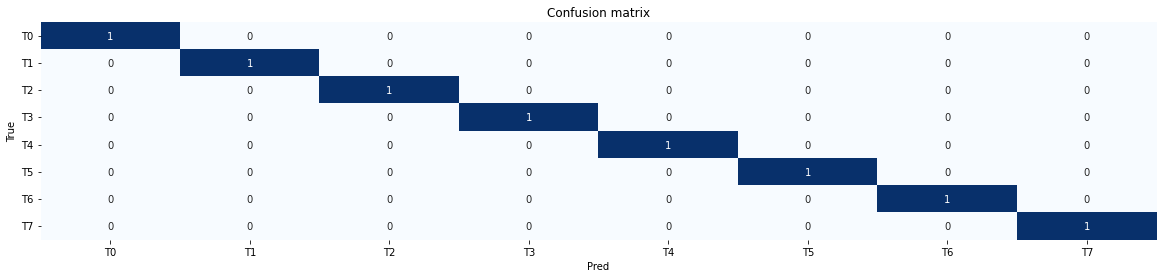

In [14]:
y_test = questions["label"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values


## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))



## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig.set_figwidth(20)




----



## Preprocessing the questions and templates

In [15]:
#Cleaning Templates with utils_preprocess_text1 + utils_preprocess_text2 AND Cleaning Question with utils_preprocess_text2

lst_stopwords = nltk.corpus.stopwords.words("english")
index=0
for sentence in templates["Template"]:
  sentence = utils_preprocess_text1(sentence)
  templates.at[index,'Template_Clean3'] = utils_preprocess_text2(sentence, flg_lemm=True, lst_stopwords=lst_stopwords)

  index=index+1

index=0
for sentence in questions["text"]:
  questions.at[index,'Text_Clean1'] = utils_preprocess_text2(sentence, flg_lemm=True, lst_stopwords=lst_stopwords)
  index=index+1

print(questions['Text_Clean1'])
print(templates['Template_Clean3'])


0                             myth santorini
1                          village santorini
2                      romantic place couple
3                          history santorini
4                              tell akrotiri
5                      santorini known thera
6    mean transport use get around santorini
7                   recommended place family
Name: Text_Clean1, dtype: object
0          historical info
1                  village
2               also known
3                     myth
4                     know
5               get around
6    family friendly place
7           romantic place
Name: Template_Clean3, dtype: object


# Linguistic Similarity

In [16]:
def Similarity_LinguisticApproach(question, templates):
  score = []
  for template in templates["Template_Clean3"]:
    sc=0
    for word in question.split():
      if word in template.split():
        sc=sc+1
    score.append(sc)

  return score    

### Calculate Second Similatrity with Similarity_LinguisticApproach

In [17]:
scores = []
for question in questions["Text_Clean1"]:
  score = Similarity_LinguisticApproach(question, templates)
  scores.append(score)

print(scores)

for s in scores:
  count=0
  for i in s:
    count=count+i
  if count==0:
    s.clear()


[[0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 2], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 2, 1]]


### Find the biggest similarity

In [18]:
predicted_prob = scores
predicted2=[]

for pred in predicted_prob:
  if pred:
    x = np.argmax(pred)
    predicted2.append("T" + str(x))
  
  else:
    predicted2.append(None)


#Template Matching
## Combining Both Methods




In [19]:
#print(predicted2)
#print(predicted)
#print(second)
Final_predictions=[]

i=0
for p1, p2 in zip(predicted, predicted2):
  if p2:
    if p2==p1:
      final_Pred = p1
    elif p2==second[i]:
      final_Pred = second[i]
    else:
      final_Pred = p2
  else:
    final_Pred = p1
  
  i=i+1
  Final_predictions.append(final_Pred)


print("Final Predictions", Final_predictions)


Final Predictions ['T3', 'T1', 'T7', 'T0', 'T4', 'T2', 'T5', 'T6']


## Presenting Accuracy, Precision, Recall and Confusion Matrix for the Final Predictions

Accuracy: 1.0
Detail:
              precision    recall  f1-score   support

          T0       1.00      1.00      1.00         1
          T1       1.00      1.00      1.00         1
          T2       1.00      1.00      1.00         1
          T3       1.00      1.00      1.00         1
          T4       1.00      1.00      1.00         1
          T5       1.00      1.00      1.00         1
          T6       1.00      1.00      1.00         1
          T7       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



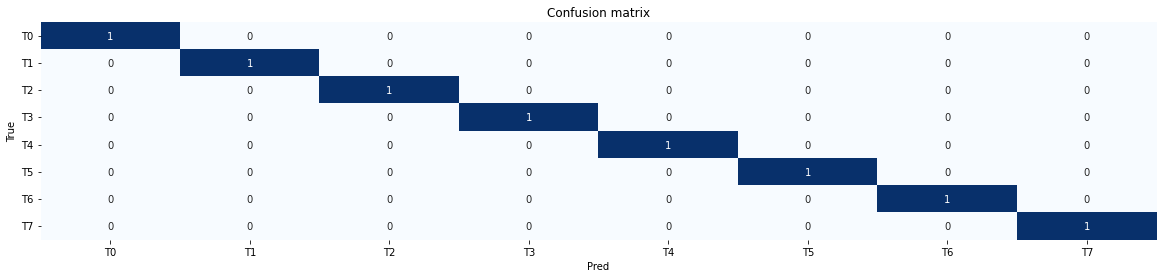

In [20]:
y_test = questions["label"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values


## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, Final_predictions)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, Final_predictions))



## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, Final_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig.set_figwidth(20)



---



# Answer Retrieval

## Preprocessing templates

In [21]:
index=0
for cyph_q in templates["Cypher"]:
  new_cyph_q = re.sub("<+[\w]*>", "#", cyph_q)
  templates.at[index,'Cypher_Clean'] = new_cyph_q
  index=index+1
  
templates["Cypher_Clean"].head()

0    MATCH (p) WHERE p.ns0__name = "#" RETURN p.ns1...
1    MATCH (start{ns0__name:"Santorini"})-[r:ns0__c...
2    MATCH (start{ns0__name:"Santorini"})-[r:ns1__A...
3    MATCH (start{ns0__name:"#"})-[r:ns1__Myths]->(...
4    MATCH p=(start{ns0__name:"#"})-[r]->(end) RETU...
Name: Cypher_Clean, dtype: object

## Connecting to Neo4j

In [22]:
!pip install py2neo
from py2neo import Graph

graph = Graph("neo4j+s://b6c3be65.databases.neo4j.io", auth=("neo4j", "santorinikg2023"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## For each question fetching the appropriate cypher query and returning the right answer

In [23]:
def answer_Retrieval(Final_prediction, Question, templates):
  #fetching the appropriate template
  template_index = int(Final_prediction[1])
  cypher_query = templates["Cypher_Clean"].iloc[template_index]

  if cypher_query.count("#") > 0:
    cypher_query = QA_NER(Question, cypher_query)
    
  answer = graph.run(cypher_query).to_data_frame()
  
  return answer

In [24]:
def QA_NER(Question, cypher_query):
  NER = spacy.load("en_core_web_sm")
  
  #Truecasing the questions in order to apply NER method 
  n = truecase.get_true_case(Question)
  #Using NER to find the key entity that is required in the cypher query
  entities = NER(n)

  if cypher_query.count("#") == 1:
    for word in entities.ents:
      cypher_query = cypher_query.replace("#", str(word))
    
  elif cypher_query.count("#") == entities.ents.count:
    indexes = [x.start() for x in re.finditer('\#', cypher_query)]
        
    for i, word in zip(indexes, entities.ents):
      cypher_query = cypher_query[:i] + str(word) + cypher_query[i+1:] 
        
  return cypher_query

In [25]:
for q, p in zip(questions["text"], Final_predictions):
  print("Question: ", q)
  answer = answer_Retrieval(p , q, templates)
  print("Answer:\n", answer)

Question:  Are there any myths about santorini
Answer:
       Entity    Relation           Entity2_Name  \
0  Santorini  ns1__Myths  Lost City of Atlantis   

                                 Entity2_Description  
0  Santorini has often been connected with Atlant...  
Question:  What are the villages of Santorini?
Answer:
        Entity            Relation  \
0   Santorini  ns0__containsPlace   
1   Santorini  ns0__containsPlace   
2   Santorini  ns0__containsPlace   
3   Santorini  ns0__containsPlace   
4   Santorini  ns0__containsPlace   
5   Santorini  ns0__containsPlace   
6   Santorini  ns0__containsPlace   
7   Santorini  ns0__containsPlace   
8   Santorini  ns0__containsPlace   
9   Santorini  ns0__containsPlace   
10  Santorini  ns0__containsPlace   
11  Santorini  ns0__containsPlace   
12  Santorini  ns0__containsPlace   
13  Santorini  ns0__containsPlace   
14  Santorini  ns0__containsPlace   
15  Santorini  ns0__containsPlace   
16  Santorini  ns0__containsPlace   
17  Santo

## Recommend next question the user might be interested in

In [26]:
def recommendation_retrieval(Sec_prediction, previous_question, templates):
  #fetching the appropriate template
  template_index = int(Sec_prediction[1])
  cypher_query = templates["Cypher_Clean"].iloc[template_index]

  NER = spacy.load("en_core_web_sm")
  n = truecase.get_true_case(previous_question)
  #Using NER to find the key entity that is required in the cypher query
  entities = NER(n)

  if cypher_query.count("#") > 0:
    for word in entities.ents:
      cypher_query = cypher_query.replace("#", str(word))
    print(cypher_query)    

  answer = graph.run(cypher_query).to_data_frame()
  
  return answer

In [27]:
for q, p, s in zip(questions["text"], Final_predictions, second):
  if p != s:
    #fetching the appropriate template
    template_index = int(s[1])
    nl = templates["Template"].iloc[template_index]
    
    print("Would you like to know more about: ", nl)

    input1 = input("Type YES/NO to continue: ")
    if input1.upper() == "YES":
      answer2 = recommendation_retrieval(s, q, templates)
      print("Answer:\n", answer2)    

    print("Thank you! Bye Bye! :)")

Would you like to know more about:  Historical Info about <Place>
Type YES/NO to continue: Yes
MATCH (p) WHERE p.ns0__name = "Santorini" RETURN p.ns1__Brief_History AS Brief_History;
Answer:
                                       Brief_History
0  https://www.santorini.com/santorini/history.html
Thank you! Bye Bye! :)
Would you like to know more about:  What are some family friendly places?
Type YES/NO to continue: Yes
Answer:
       Entity            Relation Entity2_Name
0  Santorini  ns0__containsPlace       Kamari
Thank you! Bye Bye! :)
Would you like to know more about:  What are some family friendly places?
Type YES/NO to continue: Yes
Answer:
       Entity            Relation Entity2_Name
0  Santorini  ns0__containsPlace       Kamari
Thank you! Bye Bye! :)
Would you like to know more about:  What are some romantic places?
Type YES/NO to continue: Yes
Answer:
       Entity            Relation Entity2_Name
0  Santorini  ns0__containsPlace     Akrotiri
1  Santorini  ns0__containsPla